<a href="https://colab.research.google.com/github/BLayus/Sales-Prediction/blob/main/Rossmann_Store_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importando Bibliotecas e Datasets

In [1]:
!pip install inflection

# Biblioteca para trabalhar com strings, renomear colunas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Imports

import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import inflection
import math

import calendar

import datetime


In [3]:
# Supress Scientific Notation

np.set_printoptions(suppress=True)
pd.set_option('display.float_format', '{:.2f}'.format)


In [4]:
# Dataset from github


df_sales = pd.read_csv('https://raw.githubusercontent.com/BLayus/Sales-Prediction/main/Datasets/train.csv', low_memory= False)

df_store = pd.read_csv('https://raw.githubusercontent.com/BLayus/Sales-Prediction/main/Datasets/store.csv', low_memory= False)

In [5]:
df_sales.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
1,2,a,a,570.00,11.00,2007.00,1,13.00,2010.00,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.00,12.00,2006.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct"
3,4,c,c,620.00,9.00,2009.00,0,NaN,NaN,NaN
4,5,a,a,29910.00,4.00,2015.00,0,NaN,NaN,NaN


In [7]:
# Observa-se a necessidade de unir as duas tabelas. A primeira mostra as vendas por data de cada loja e a segunda mostra todas as lojas com outros atributos.
# A coluna store será usada para juntar as tabelas e o nível de granularidsade será o da tabela sales

In [8]:
# Merge (Join) entre os datasets

df_raw = pd.merge(df_sales, df_store, how='left', on= 'Store')

In [9]:
# As tabelas foram mergeadas com sucesso

df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
400867,1030,3,2014-07-09,2448,252,1,0,0,0,a,a,36410.00,4.00,2008.00,0,NaN,NaN,NaN


## Descrição dos Dados

In [10]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [11]:
df_raw.shape

# São aprox 1 milhão de linhas com 18 colunas, um dataset médio/grande

(1017209, 18)

In [12]:
# Fazendo uma cópia do df_raw

df1 = df_raw.copy()

# Criando uma lista com nomes de colunas antes do rename

cols_old = df1.columns

# Criando uma função para renomear as colunas

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map(snakecase, cols_old))

df1.columns = cols_new

print(df1.columns)

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')


In [13]:
# Mostrando shape, número de linhas e colunas

print(f'Número de Linhas: {df1.shape[0]}')
print(f'Número de Colunas: {df1.shape[1]}')

Número de Linhas: 1017209
Número de Colunas: 18


In [14]:
# Mostrando os data types

df1.dtypes


store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [15]:
# vamos precisar converter alguns tipos de dados para os formatos corretos
# date está como object e tem que ser datetime

df1['date'] = pd.to_datetime(df1['date'], errors= 'coerce')

In [16]:
df1.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
683372,663,7,2013-10-27,0,0,0,0,0,0,a,c,7860.00,5.00,2005.00,0,NaN,NaN,NaN
1010860,341,7,2013-01-06,0,0,0,0,0,0,a,a,190.00,9.00,2011.00,0,NaN,NaN,NaN
619320,166,1,2013-12-23,16335,2094,1,0,0,1,a,c,100.00,4.00,2014.00,1,31.00,2013.00,"Jan,Apr,Jul,Oct"
517449,875,2,2014-03-25,3989,405,1,0,0,0,d,a,5070.00,11.00,2007.00,1,18.00,2015.00,"Feb,May,Aug,Nov"
546242,678,4,2014-02-27,5273,708,1,0,0,0,c,a,3250.00,NaN,NaN,1,40.00,2011.00,"Jan,Apr,Jul,Oct"


In [17]:
# Avaliando as colunas que possuem linhas com dados faltantes

df1.isna().sum()


store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

<Axes: >

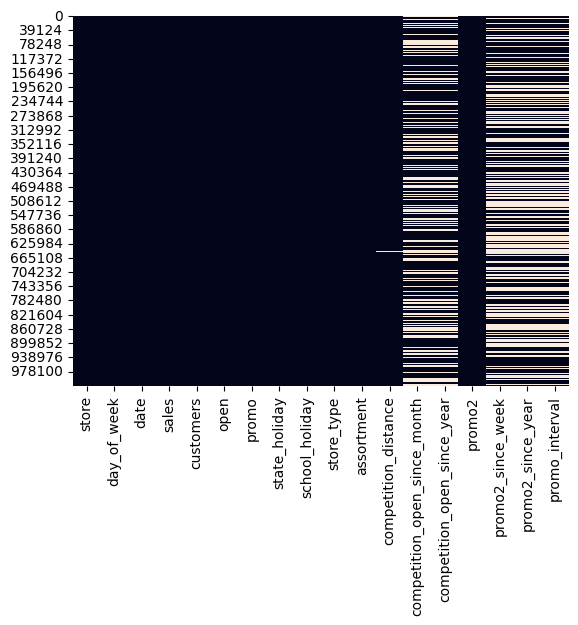

In [18]:
# Avaliando dados faltantes através de representação gráfica com heatmap
sns.heatmap(df1.isnull(), cbar=False)

In [19]:
# Substituindo dados faltantes

# competition_distance (distância em metros de uma loja concorrente)
# Hipótese: não há nenhuma loja concorrente nas proximidades, assumir que a loja concorrente mais próxima está tão distante que não representa concorrência

df1['competition_distance'] = df1['competition_distance'].apply (lambda x: 200000 if math.isnan(x) else x )

# competition_open_since_month
# Hipótese: Não tem concorrente próximo, não sabemos quando a loja foi aberta. Assumir a data de venda como data da loja concorrente aberta

df1['competition_open_since_month'] = df1.apply (lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year

df1['competition_open_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week
# loja decidiu não participar da promoção, valor promo2 = 0

df1['promo2_since_week'] = df1.apply (lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
# Mesma hipótese da promo2_since_week

df1['promo2_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
# Hipótese: crtiar uma nova coluna onde 0 significa que a loja não continuou a promo2 e 1 significa que a loja continuou a promo2

month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12:'Dec'}

df1['promo_interval']. fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply (lambda x: 0 if x['promo_interval'] == 0
                                                              else 1 if x['month_map'] in x['promo_interval'].split(',')
                                                              else 0, axis=1)


In [20]:
df1.sample(5).T

,853427,909060,342803,466050,52517
store,123,6,924,766,113
day_of_week,1,7,2,6,7
date,2013-05-27 00:00:00,2013-04-07 00:00:00,2014-09-09 00:00:00,2014-05-10 00:00:00,2015-06-14 00:00:00
sales,12013,0,4230,6469,0
customers,1267,0,444,621,0
open,1,0,1,1,0
promo,1,0,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,a,a,d,d


<Axes: >

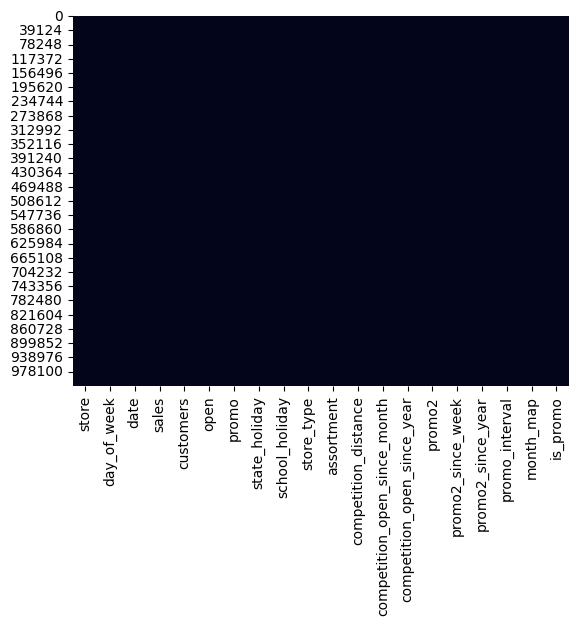

In [21]:
# Avaliando quantos NaN ficaram no dataset através de um heatmap, um mapa das posições nulas no dataset


sns.heatmap(df1.isnull(), cbar=False)

In [22]:
# Verificando nulos com valores totais
df1.isna().sum()


store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [23]:
# Verificando nulos com valores percentuais
df1.isna().sum() / df1.shape[0] * 100

store                          0.00
day_of_week                    0.00
date                           0.00
sales                          0.00
customers                      0.00
open                           0.00
promo                          0.00
state_holiday                  0.00
school_holiday                 0.00
store_type                     0.00
assortment                     0.00
competition_distance           0.00
competition_open_since_month   0.00
competition_open_since_year    0.00
promo2                         0.00
promo2_since_week              0.00
promo2_since_year              0.00
promo_interval                 0.00
month_map                      0.00
is_promo                       0.00
dtype: float64

In [24]:
# Acertando tipos de dados

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [25]:
# Alterando tipos de dados de algumas colunas que aparecem como float e podem ser int

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)

df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)

## Estatistica Descritiva

In [26]:
# Medidas de tendência central, média, mediana, etc
# Medidas de dispersão, como desvio padrão, variância, distribuição, etc


In [27]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo'],
      dtype='object')

In [28]:
# Separando as variáveis numéricas das variáveis categóricas olhando para cada coluna sem usar dtypes
# forma mais inteligente de separar as colunas com valores numéricos das com valores categóricos e identificadores

# store => numeração da loja , não é uma variável numérica contínua, por isso pode ser considerada apenas uma identificação da loja - Var. Identificadora
# day of week => variável dummyficada de 1 a 7 que identifica atrevés de código numérico os dias da semana - Var. Categórica
# date => não é numérica contínua, apenas identifica a data da compra - Var. Identificadora
# sales => variável numérica contínua que mostra o valor total das vendas de determinada loja em determinada data - Var. Numérica
# customers => variável numérica contínua que mostra a quantidade total de clientes de determinada loja em determinada data - Var. Numérica
# open => variável dummyficada, que identifica através de código se a loja estava ou não aberta naquela data - Var. Categórica
# promo => variável dummyficada que identifica se a loja estava ou não em promo - Var. Categórica
# state holiday => Variável dummyficada que indica se é ou não feriado - Var. Categórica
# school holiday => Variável dummy que indica o tipo de feriado ou férias escolares - Var. categórica
# store type => Variável duumy que indica o tipo da loja - Var. Categórica
# assortment => variável dummyficada que indica a variedade de produtos da loja - Var. categórica
# competition distance => variável numérica copntínua que indica a distância da loja concorrente mais próxima - Var. Numérica
# competition_open_since_month e competition_open_since_year => variáveis numéricas que indicam há quanto tempo a loja concorrente está aberta - Var. Numérica
# promo2 => indica se a loja aderiu ou não à promo2 - Var. Categórica
# promo2_since_week e promo2_since_year => variáveis contínuas que indicam há quanto tempo a loja está com a promo 2 - Var. Numérica
# promo_interval => variável categórica que indica em quais meses a promo foi feita, mexemos nela para criar uma forma mais interpretativa
# month map => variável que indica o mês da data daquele registro, auxiliar para a coluna is promo
# is promo => variável categórica que indica se a loja está ou não em promo naquela data - Var. categórica


In [29]:
# Separando as variáveis numéricas das variáveis categóricas

#num_variables = df1.select_dtypes(include= ['int64', 'float64'])
#cat_variables = df1.select_dtypes(exclude= ['int64', 'float64', 'datetime64[ns]'])

num_var = df1[['sales', 'customers', 'competition_distance', 'competition_open_since_month',
              'competition_open_since_year', 'promo2_since_week', 'promo2_since_year']]

cat_var = df1[['assortment', 'day_of_week', 'open', 'promo', 'state_holiday', 'school_holiday', 'store_type',
              'assortment', 'promo2', 'is_promo']]

In [30]:
# Mostrando médias e medianas das variáveis numéricas

ct_num_mean = pd.DataFrame(num_var.apply (np.mean)).T
ct_num_median = pd.DataFrame(num_var.apply (np.median)).T


In [31]:
# Medidas de dispersão

disp_std = pd.DataFrame(num_var.apply(np.std)).T
disp_min = pd.DataFrame(num_var.apply(min)).T
disp_max = pd.DataFrame(num_var.apply(max)).T
disp_range = pd.DataFrame(num_var.apply(lambda x: x.max() - x.min())).T
disp_skew = pd.DataFrame(num_var.apply(lambda x: x.skew())).T
disp_kurtosis = pd.DataFrame(num_var.apply(lambda x: x.kurtosis())).T

In [32]:
# Concatenando todas as métricas em uma só tabela

metrics = pd.concat([disp_min, disp_max, disp_range, ct_num_mean, ct_num_median, disp_std, disp_skew, disp_kurtosis]).T.reset_index()

metrics.columns= ['Atributos', 'Min', 'Max', 'Range', 'Média', 'Mediana', 'Desvio Padrão', 'Skewness', 'Kurtosis']

metrics

,Atributos,Min,Max,Range,Média,Mediana,Desvio Padrão,Skewness,Kurtosis
0,sales,0.00,41551.00,41551.00,5773.82,5744.00,3849.92,0.64,1.78
1,customers,0.00,7388.00,7388.00,633.15,609.00,464.41,1.60,7.09
2,competition_distance,20.00,200000.00,199980.00,5935.44,2330.00,12547.65,10.24,147.79
3,competition_open_since_month,1.00,12.00,11.00,6.79,7.00,3.31,-0.04,-1.23
4,competition_open_since_year,1900.00,2015.00,115.00,2010.32,2012.00,5.52,-7.24,124.07
5,promo2_since_week,1.00,52.00,51.00,23.62,22.00,14.31,0.18,-1.18
6,promo2_since_year,2009.00,2015.00,6.00,2012.79,2013.00,1.66,-0.78,-0.21


In [33]:
# Podemos usar a função describe pra avaliar várias métricas padrão de uma só vez

num_var.describe().round(2)

,sales,customers,competition_distance,competition_open_since_month,competition_open_since_year,promo2_since_week,promo2_since_year
count,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00
mean,5773.82,633.15,5935.44,6.79,2010.32,23.62,2012.79
std,3849.93,464.41,12547.65,3.31,5.52,14.31,1.66
min,0.00,0.00,20.00,1.00,1900.00,1.00,2009.00
25%,3727.00,405.00,710.00,4.00,2008.00,12.00,2012.00
50%,5744.00,609.00,2330.00,7.00,2012.00,22.00,2013.00
75%,7856.00,837.00,6910.00,10.00,2014.00,37.00,2014.00
max,41551.00,7388.00,200000.00,12.00,2015.00,52.00,2015.00


In [34]:
cat_var.describe().round(2)

,day_of_week,open,promo,school_holiday,promo2,is_promo
count,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00
mean,4.00,0.83,0.38,0.18,0.50,0.17
std,2.00,0.38,0.49,0.38,0.50,0.37
min,1.00,0.00,0.00,0.00,0.00,0.00
25%,2.00,1.00,0.00,0.00,0.00,0.00
50%,4.00,1.00,0.00,0.00,1.00,0.00
75%,6.00,1.00,1.00,0.00,1.00,0.00
max,7.00,1.00,1.00,1.00,1.00,1.00


array([[<Axes: title={'center': 'sales'}>,
        <Axes: title={'center': 'customers'}>,
        <Axes: title={'center': 'competition_distance'}>],
       [<Axes: title={'center': 'competition_open_since_month'}>,
        <Axes: title={'center': 'competition_open_since_year'}>,
        <Axes: title={'center': 'promo2_since_week'}>],
       [<Axes: title={'center': 'promo2_since_year'}>, <Axes: >,
        <Axes: >]], dtype=object)

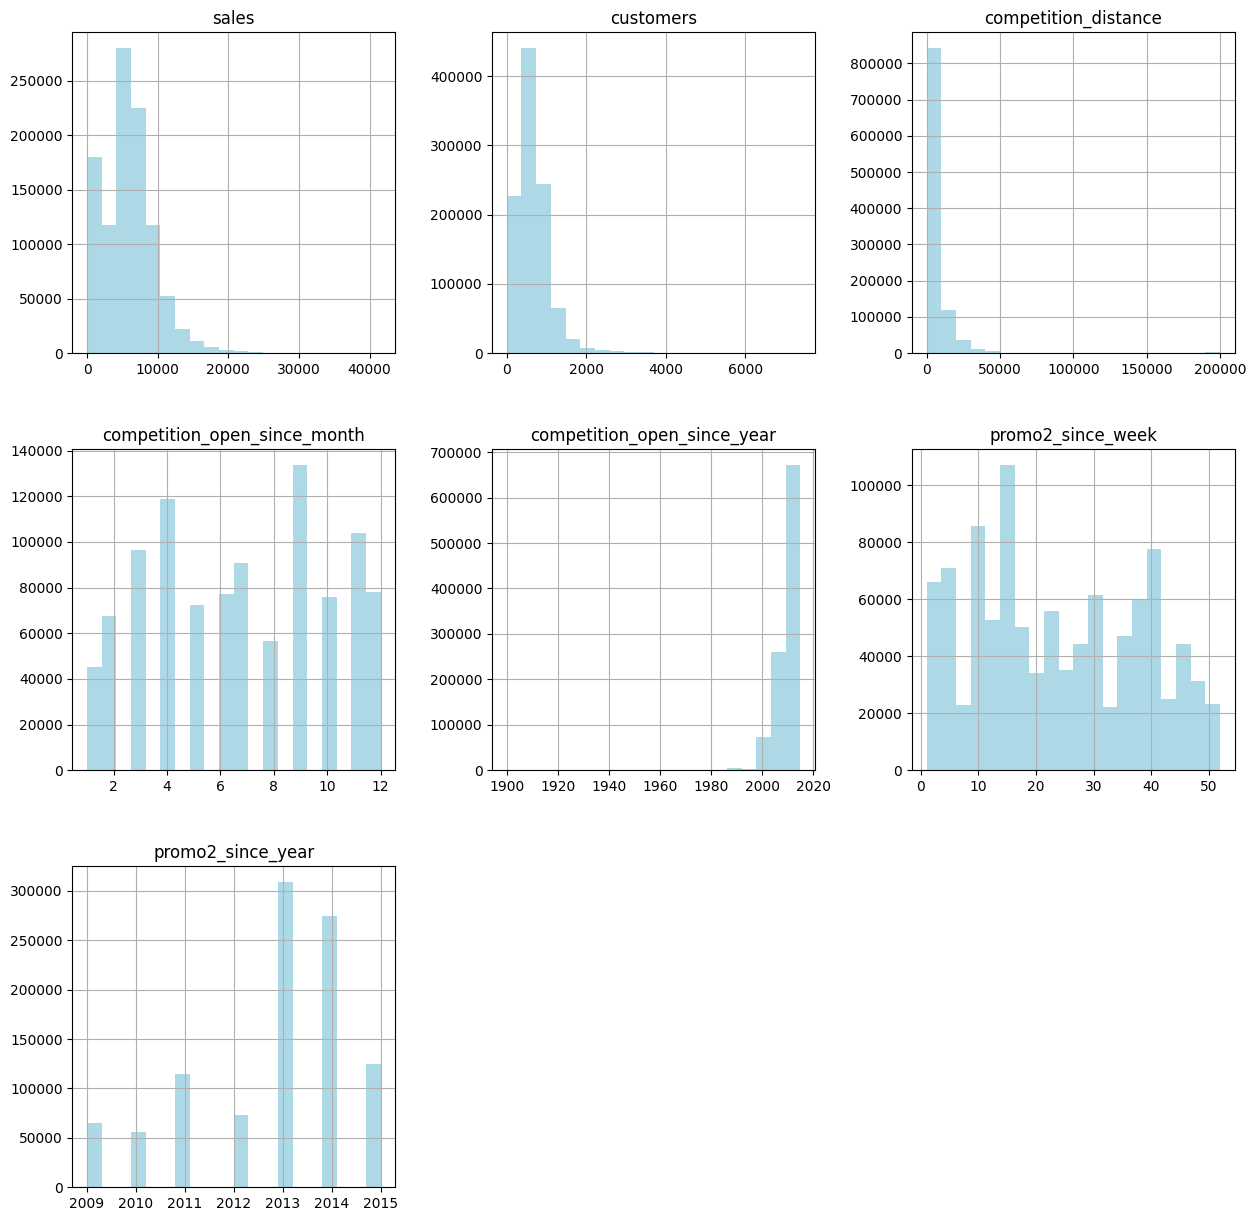

In [35]:
# Plotando gráficos para ver as distribuições
# Relacionar valores de vendas com as outras features

num_var.hist(bins=20, figsize=(15, 15), color='lightblue')

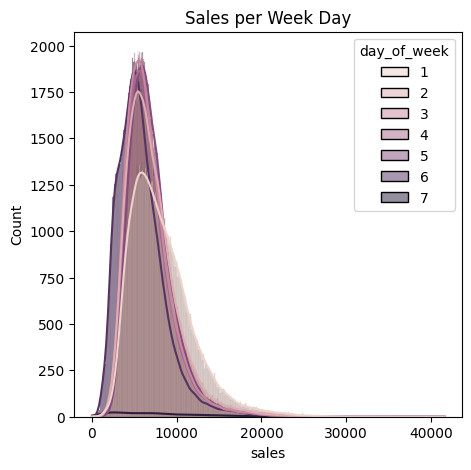

In [36]:
# Relacionando valores de vendas com os dias da semana

df_aux = df1[df1['sales']!= 0]

fig, ax = plt.subplots(figsize=(5,5))
ax = sns.histplot(data= df_aux, x= 'sales', hue= 'day_of_week', kde= True)
ax.set_title('Sales per Week Day')
ax.set_xlabel= 'Sales'
ax.set_ylabel= 'Count'
plt.show()

In [37]:
# Criando um dataframe com a soma de vendas por dia da semana

d2 = df_aux[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

d2

,day_of_week,sales
0,1,1130203012
1,2,1020411930
2,3,954962863
3,4,911177709
4,5,980555941
5,6,846317735
6,7,29551433


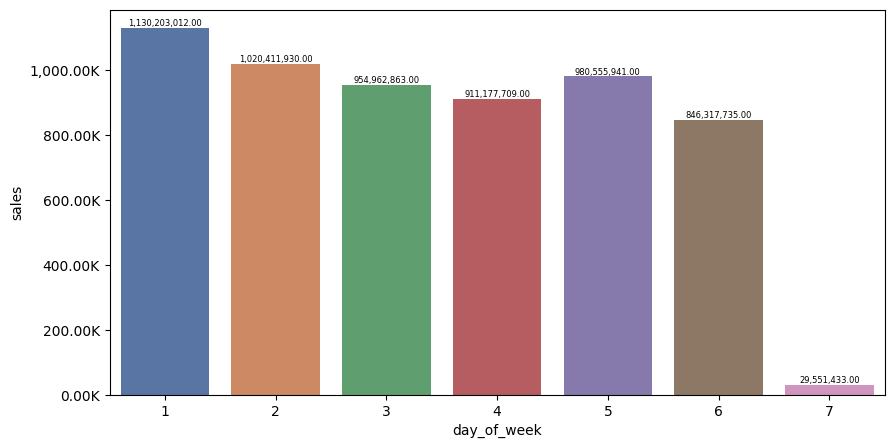

In [38]:
# Plotando a soma total de vendas por dia da semana

fig, ax = plt.subplots(figsize= (10,5))
ax = sns.barplot(x= 'day_of_week', y= 'sales', data= d2, palette= 'deep')

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000000) + 'K'))
ax.bar_label(ax.containers[0], fmt='{:,.2f}', fontsize=6)
plt.show()

In [39]:
# Calculando média por dia

d3 = df_aux[['day_of_week', 'sales', 'customers', 'open']].groupby('day_of_week').mean().reset_index()
d3

,day_of_week,sales,customers,open
0,1,8216.25,855.46,1.00
1,2,7088.41,770.02,1.00
2,3,6728.79,740.67,1.00
3,4,6768.21,755.67,1.00
4,5,7073.03,781.81,1.00
5,6,5875.08,660.21,1.00
6,7,8224.72,1441.53,1.00


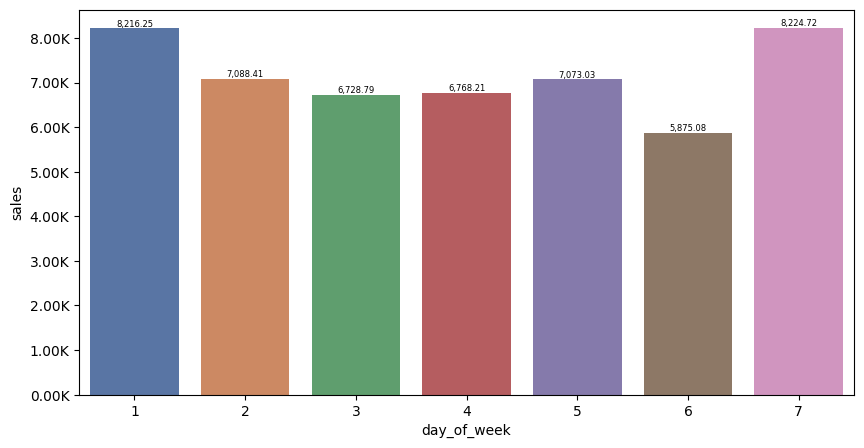

In [40]:
# Plotando a média de vendas por dia da semana

fig, ax = plt.subplots(figsize= (10,5))
ax = sns.barplot(x= 'day_of_week', y= 'sales', data= d3, palette= 'deep')

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000) + 'K'))
ax.bar_label(ax.containers[0], fmt='{:,.2f}', fontsize=6)
plt.show()

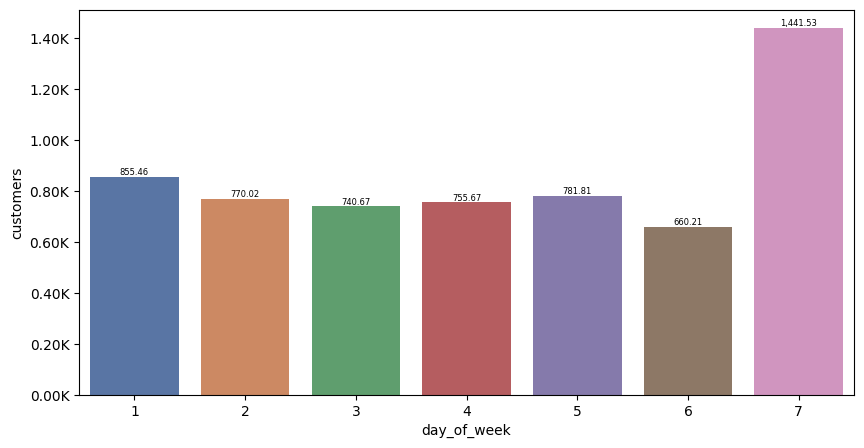

In [41]:
# Plotando numero de clientes médio por dia da semana

fig, ax = plt.subplots(figsize= (10,5))
ax = sns.barplot(x= 'day_of_week', y= 'customers', data= d3, palette= 'deep')

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000) + 'K'))
ax.bar_label(ax.containers[0], fmt='{:,.2f}', fontsize=6)
plt.show()

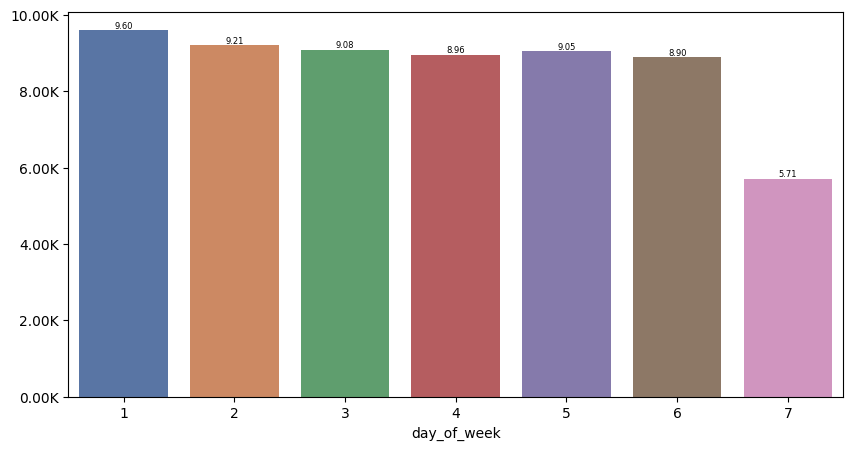

In [42]:
# Avaliando ticket médio de gastos por cliente por dia da semana
# Total de vendas média por dia / clientes média por dia

fig, ax = plt.subplots(figsize= (10,5))
ax = sns.barplot(x= 'day_of_week', y= (d3['sales'] / d3['customers']), data= d3, palette= 'deep')

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x) + 'K'))
ax.bar_label(ax.containers[0], fmt='{:,.2f}', fontsize=6)
plt.show()

#### Como interpretar estes gráficos com movimento de clientes e faturamento por dia da semana?

* O dia da semana com menor soma de faturamento bruto é o dia 7 (domingo), enqanto os demais dias mantém aproximadamente a mesma soma de faturamento bruto, liderados pela segunda-feira, seguido pela terça-feira e depois a sexta-feira. Esses dados são válidos apenas para os dias em que as lojas realizaram alguma venda, o que também significa que a loja estava aberta naquele dia.

* Apesar disso, domingo é o dia que possui a maior média de faturamento por dia da semana e o maior número de clientes, porém é o dia com menor ticket médio.

* Isso pode ser por conta dos dias com lojas fechadas, nem todas as lojas ficam abertas aos domingos.

In [43]:
# verificando se de fato as lojas ficam fechadas aos domingos

# De fato, das lojas que possuem ao menos uma venda, a minoria delas fica aberta aos domingos
# Curiosamente, após o domingo, sexta é o dia que mais tem lojas fechadas e segunda é o terceiro dia com mais lojas fechadas

df1[['open', 'day_of_week']].groupby(['day_of_week', 'open']).value_counts()

day_of_week  open
1            0         7170
             1       137560
2            0         1703
             1       143961
3            0         3729
             1       141936
4            0        11201
             1       134644
5            0         7205
             1       138640
6            0          672
             1       144058
7            0       141137
             1         3593
dtype: int64

In [44]:
# Ampliando a análise para uma visão anual das vendas por mês

month_ordered = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

df_anual = df_aux[['month_map', 'sales', 'customers']].groupby('month_map').sum().reindex(month_ordered, axis=0).reset_index()
df_anual

,month_map,sales,customers
0,Jan,566728724,62384091
1,Feb,528734410,58698139
2,Mar,599831906,65265836
3,Apr,575895295,63282001
4,May,569248217,62423484
5,Jun,578112775,62698087
6,Jul,595059205,64425231
7,Aug,361791202,40830683
8,Sep,342570131,39017980
9,Oct,351878728,40106150


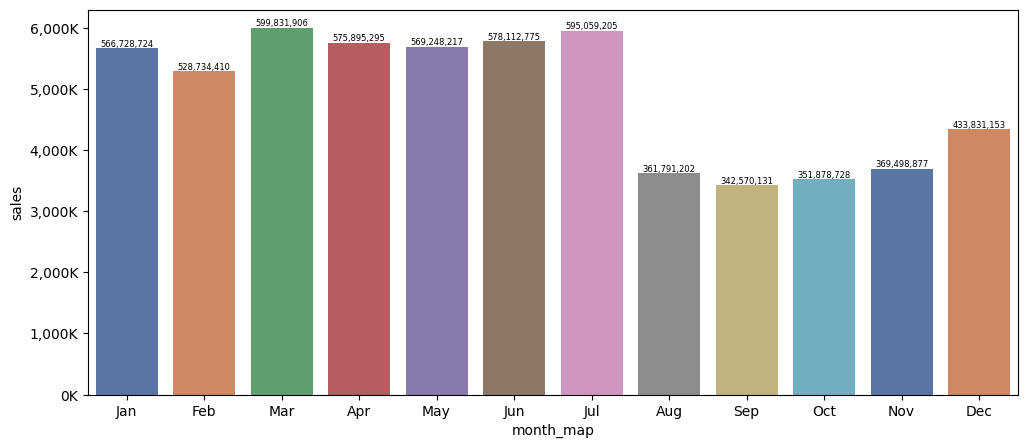

In [45]:
# Plotando ano mês a mês

fig, ax = plt.subplots(figsize= (12,5))
ax = sns.barplot(x= 'month_map', y= 'sales', data= df_anual, palette= 'deep')

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/100000) + 'K'))
ax.bar_label(ax.containers[0], fmt='{:,.0f}', fontsize=6)
plt.show()

In [46]:
# Ampliando a análise para uma visão anual das vendas por mês média de vendas

month_ordered = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

df_mean = df_aux[['month_map', 'sales', 'customers']].groupby('month_map').mean().reindex(month_ordered, axis=0).reset_index()
df_mean

,month_map,sales,customers
0,Jan,6564.30,722.58
1,Feb,6589.49,731.54
2,Mar,6976.82,759.13
3,Apr,7046.66,774.32
4,May,7106.81,779.33
5,Jun,7001.40,759.32
6,Jul,6953.58,752.84
7,Aug,6649.23,750.41
8,Sep,6547.47,745.74
9,Oct,6602.97,752.59


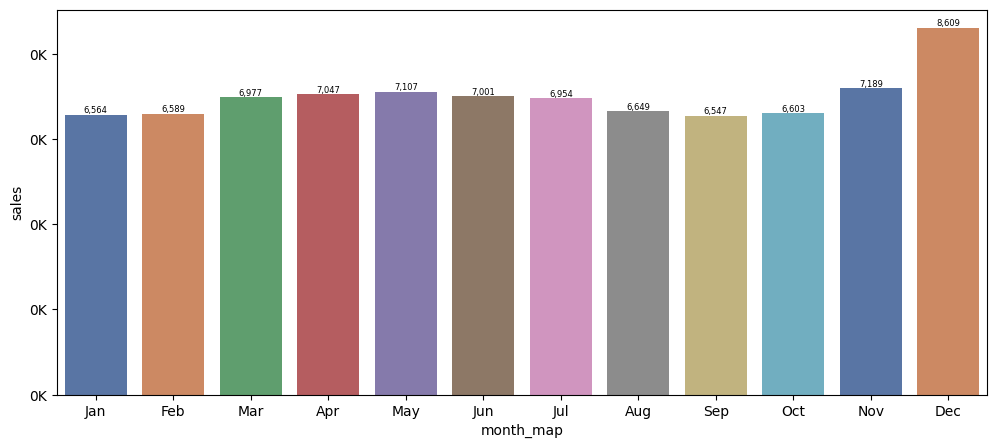

In [47]:
# Plotando ano mês a mês a média por mês

fig, ax = plt.subplots(figsize= (12,5))
ax = sns.barplot(x= 'month_map', y= 'sales', data= df_mean, palette= 'deep')

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/100000) + 'K'))
ax.bar_label(ax.containers[0], fmt='{:,.0f}', fontsize=6)
plt.show()

In [48]:
# Avaliando as vendas em lojas com e sem promoção, há uma diferença significativa?

df5 = df_aux[['promo2', 'sales', 'month_map']].groupby('month_map').sum().reindex(month_ordered, axis=0).reset_index()
df5


,month_map,promo2,sales
0,Jan,44041,566728724
1,Feb,41076,528734410
2,Mar,43940,599831906
3,Apr,41737,575895295
4,May,40796,569248217
5,Jun,42034,578112775
6,Jul,42001,595059205
7,Aug,26042,361791202
8,Sep,25048,342570131
9,Oct,25586,351878728


In [49]:
df5 = df1.groupby(by=['promo2', df1.date.dt.strftime('%b')])['sales'].sum().reset_index()

df5

,promo2,date,sales
0,0,Apr,299042517
1,0,Aug,199145812
2,0,Dec,236998266
3,0,Feb,274314844
4,0,Jan,292974945
5,0,Jul,319447682
6,0,Jun,299754172
7,0,Mar,309056770
8,0,May,296224149
9,0,Nov,203251578


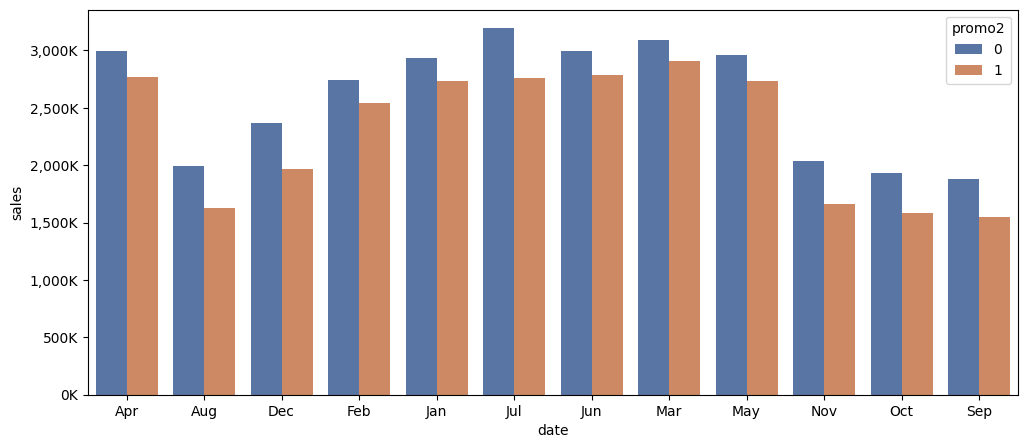

In [50]:
# Plotando ano mês a mês a diferença nas vendas entre lojas com ou sem promo2

fig, ax = plt.subplots(figsize= (12,5))
ax = sns.barplot(x= 'date', y= 'sales', hue= 'promo2', data= df5, palette= 'deep')

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/100000) + 'K'))
#ax.bar_label(ax.containers[0], fmt='{:,.0f}', fontsize=6)
plt.show()

In [51]:
# Mais análises serão feitas após o processo de feature engineering

## Feature Engineering

In [52]:
# Fazendo uma cópia do df1 para inserir novas colunas

df2 = df1.copy()
df2.sample()


,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
495125,851,1,2014-04-14,7741,600,1,1,0,1,d,c,2330.00,4,2014,1,49,2014,"Mar,Jun,Sept,Dec",Apr,0


In [53]:
# Criando novas colunas para os campos de data

df2['year'] = df2['date'].dt.year

df2['month'] = df2['date'].dt.month

df2['day'] = df2['date'].dt.day

df2['week_of_year'] = df2['date'].dt.isocalendar().week

df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


In [54]:
# Competition since

df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'],
                                                                month= x['competition_open_since_month'],
                                                                day= 1), axis=1)


In [55]:
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype (int)

In [56]:
# Coluna promo since

df2['promo_since'] = df2['promo2_since_year'].astype (str) + '-' + df2['promo2_since_week'].astype (str)

df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime (x + '-1', '%Y-%W-%w')
                                                                            - datetime.timedelta (days=7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply (lambda x: x.days).astype (int)

In [57]:
# Classificação do assortment

df2['assortment'] = df2['assortment'].apply(lambda x:'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

In [58]:
# Classificação do state holiday

df2['state_holiday'] = df2['state_holiday'].apply(lambda x:'public_holiday' if x == 'a'
                                                  else 'easter_holiday' if x == 'b'
                                                  else 'christmas' if x == 'c'
                                                  else 'regular_day')

In [59]:
df2.sample(5).T

,148026,516693,191669,973481,472321
store,847,119,1005,872,347
day_of_week,6,2,2,6,7
date,2015-03-21 00:00:00,2014-03-25 00:00:00,2015-02-10 00:00:00,2013-02-09 00:00:00,2014-05-04 00:00:00
sales,7457,4937,4881,7151,0
customers,1057,620,817,670,0
open,1,1,1,1,0
promo,0,0,0,0,0
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,0,0,0,0,0
store_type,c,a,a,a,d


# Filtragem das Linhas


In [62]:
# Coluna open mostra se a loja estava aberta ou fechada no dia
# se a loja estava fechada ela não vendeu e não faz sentido usá-la na análise e no modelo preditivo

# Coluna sales tb não ajuda na análise quando é 0, gerar um novo df com apenas as linhas que possuem informação relevante

df3 = df2[(df2['open'] != 0) & (df2['sales'] > 0)]


In [64]:
# Limpando colunas que não são necessárias para o aprendizado de máquina e para a análise

drop_columns = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop (drop_columns, axis=1)

In [65]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')